# Train YOLOv9 & SAM

1.   Train Yolov9 on Horse-Fence-rider
2.   Apply SAM for fence mask


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Apr 22 12:23:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000001:00:00.0 Off |                  Off |
| N/A   23C    P0    22W / 250W |    143MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os

# Step 2: Change the Working Directory
# desired_home_path = '/home/student/demo/Equistrian/'
desired_home_path = '/home/'
os.chdir(desired_home_path)

HOME = os.getcwd()
print(HOME)

/home


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [1]:
!pip install --upgrade jupyterlab jupyterlab-git

In [1]:
!git --version

git version 2.40.1


In [2]:
!git clone https://github.com/SkalskiP/yolov9.git

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 2.25 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (164/164), done.


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [3]:
%ls

Untitled.ipynb  train_yolov9_horse_fence_rider.ipynb  yolov9/


In [4]:
%cd yolov9
!pip install -r requirements.txt

/home/student/demo/Equistrian/Yolo9/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 61.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.0 MB/s eta 0:00:0000:0100:0

In [9]:
!pip --version


pip 22.3.1 from /home/student/miniconda3/lib/python3.8/site-packages/pip (python 3.8)


In [12]:
!pip install -q roboflow

In [13]:
pip install torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [14]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [15]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c-seg.pt

In [16]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c-seg.pt

In [17]:
!ls -la {HOME}/weights

total 571108
drwxrwxr-x 2 student student      4096 Apr 22 13:39 .
drwxrwxr-x 3 student student      4096 Apr 22 13:39 ..
-rw-rw-r-- 1 student student  55807471 Mar 17 00:20 gelan-c-seg.pt
-rw-rw-r-- 1 student student  51508261 Feb 18 12:36 gelan-c.pt
-rw-rw-r-- 1 student student 117203713 Feb 18 12:36 gelan-e.pt
-rw-rw-r-- 1 student student 116904429 Mar 23 01:24 yolov9-c-seg.pt
-rw-rw-r-- 1 student student 103153312 Feb 18 12:36 yolov9-c.pt
-rw-rw-r-- 1 student student 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data (Optional)

In [ ]:
#Source is input video
#Classes 17 represents horses

!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.4 --source {HOME}/data/chk02.mp4 --save-txt --classes 17


detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/chk02.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=[17], agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 1119 layers, 69470144 parameters, 0 gradients, 244.0 GFLOPs
Traceback (most recent call last):
  File "/content/yolov9/detect.py", line 232, in <module>
    main(opt)
  File "/content/yolov9/detect.py", line 227, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov9/detect.

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

Download any one dataset for training


In [20]:
%cd /home/student/demo/Equistrian/Yolo9

/home/student/demo/Equistrian/Yolo9


In [21]:
!mkdir /home/student/demo/Equistrian/Yolo9/datasets
%cd /home/student/demo/Equistrian/Yolo9/datasets

from roboflow import Roboflow
rf = Roboflow(api_key="gOwDplH3ZdDM2lhA68r5")
project = rf.workspace("equiai").project("horse_seg-6hrhn")
version = project.version(7)
dataset = version.download("yolov8")


/home/student/demo/Equistrian/Yolo9/datasets
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Horse_seg-7 in yolov8:: 100%|███████████████████| 2750/2750 [00:00<00:00, 5695.62it/s]


In [ ]:
# !mkdir {HOME}/datasets
# %cd {HOME}/datasets

# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="gOwDplH3ZdDM2lhA68r5")
# project = rf.workspace("equestrian-ai").project("fence-hurdles-detection")
# version = project.version(3)
# dataset = version.download("yolov8")


## Train Custom Model

In [24]:

# obj_pw change this from obj if you encounter any error
%cd /home/student/demo/Equistrian/Yolo9/yolov9

!python train.py \
--batch 8 --epochs 25 --img 200 --workers 8 --device 0 --min-items 0 --close-mosaic 15 \
--data /home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml \
--weights /home/student/demo/Equistrian/Yolo9/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/home/student/demo/Equistrian/Yolo9/yolov9
2024-04-22 13:47:21.739260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 13:47:21.885797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/home/student/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:.miniconda3/lib/python3.8/site-packages/tensorrt/::/home/student/miniconda3/envs/tf/lib/:/home/student/miniconda3/envs/tf/lib/
2024-04-22 13:47:21.885835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart d

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [25]:
!ls /home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp/

events.out.tfevents.1713793482.lab000001.4459.0  hyp.yaml  opt.yaml  weights


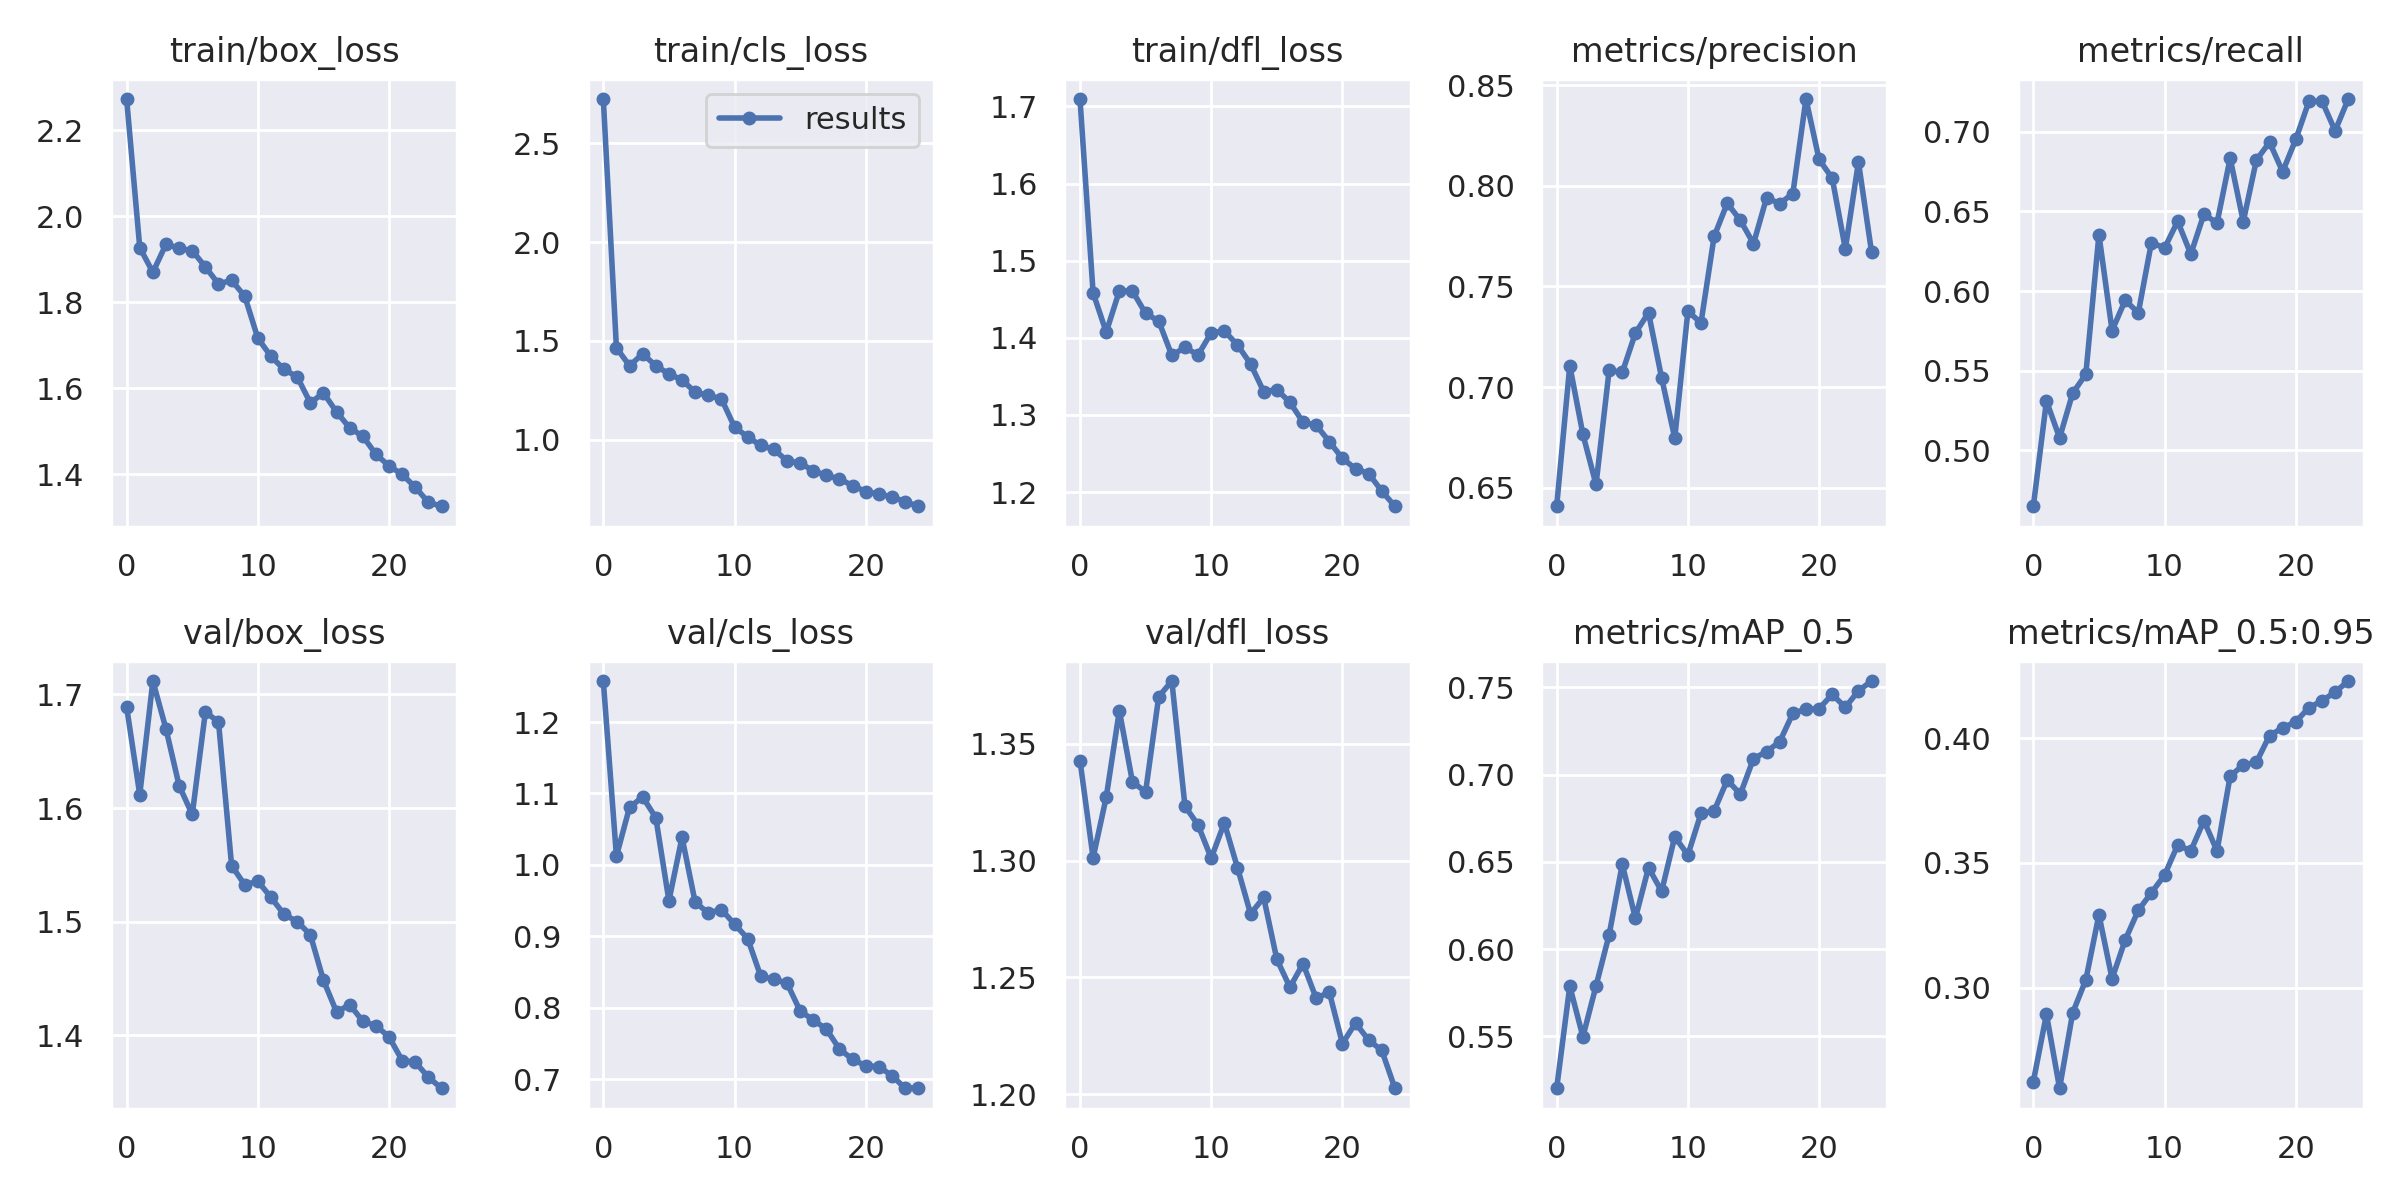

In [26]:
from IPython.display import Image

Image(filename=f"/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/results.png", width=1000)

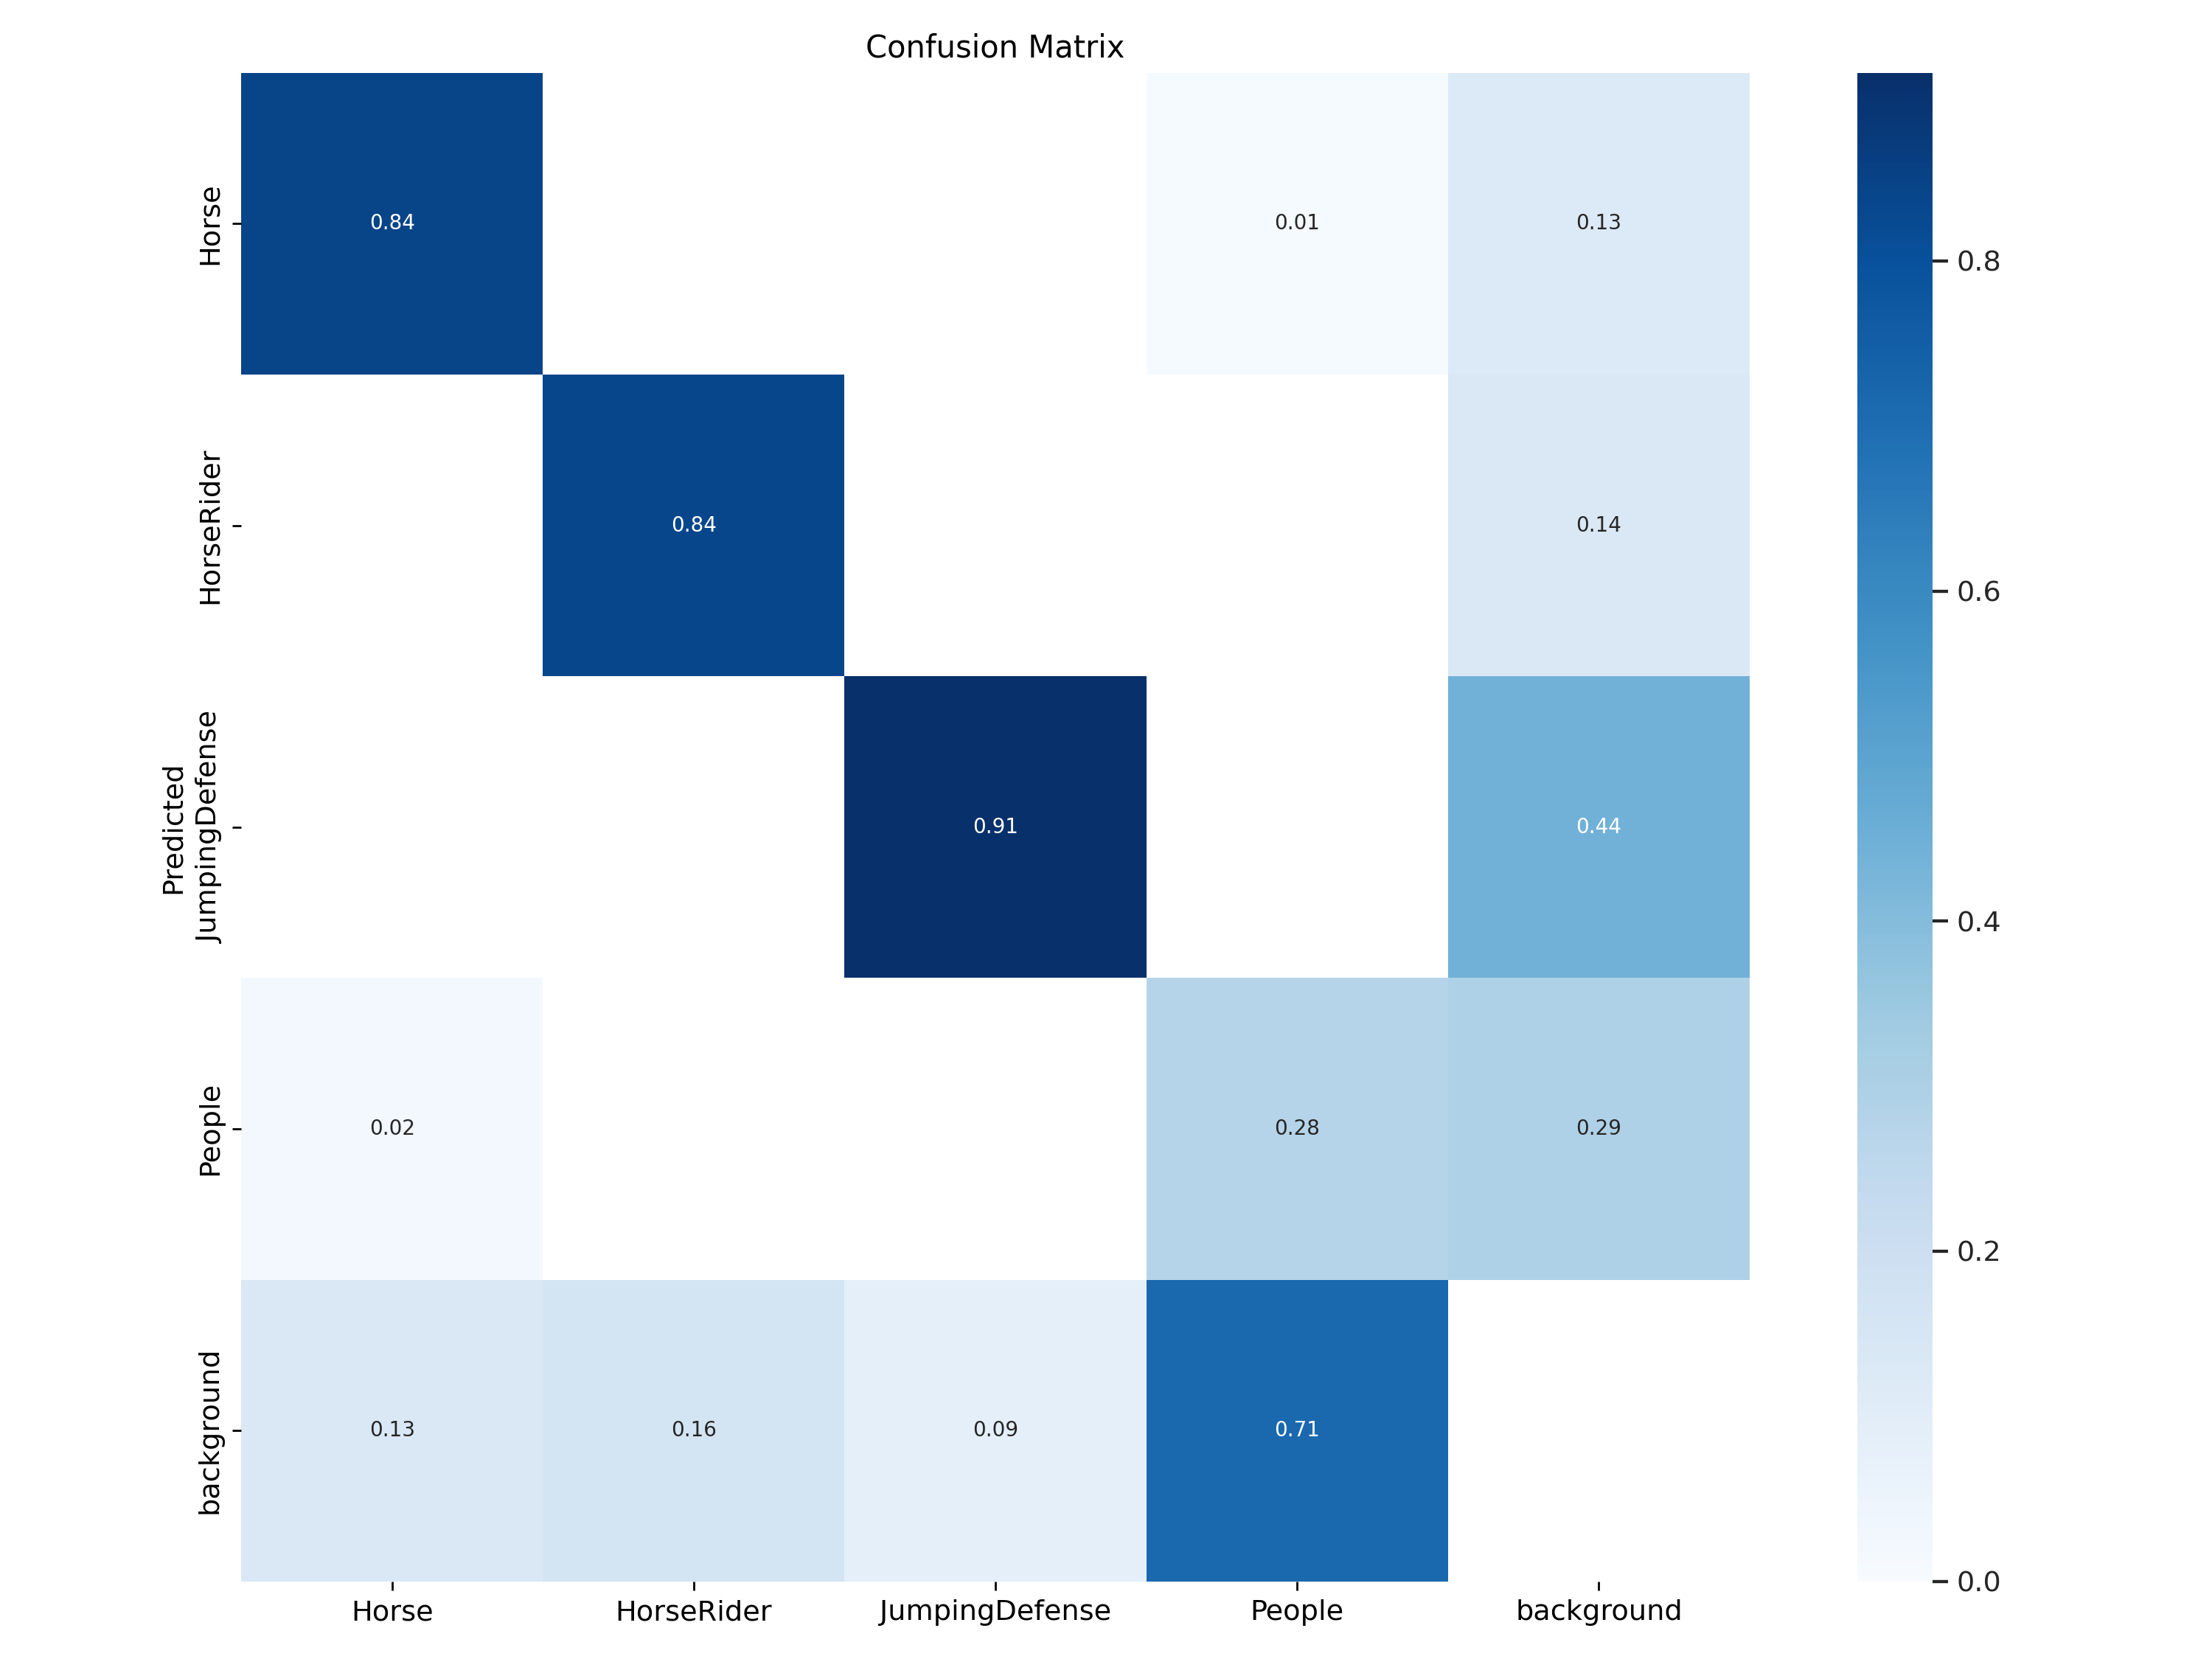

In [28]:
from IPython.display import Image

Image(filename=f"/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/confusion_matrix.png", width=1000)

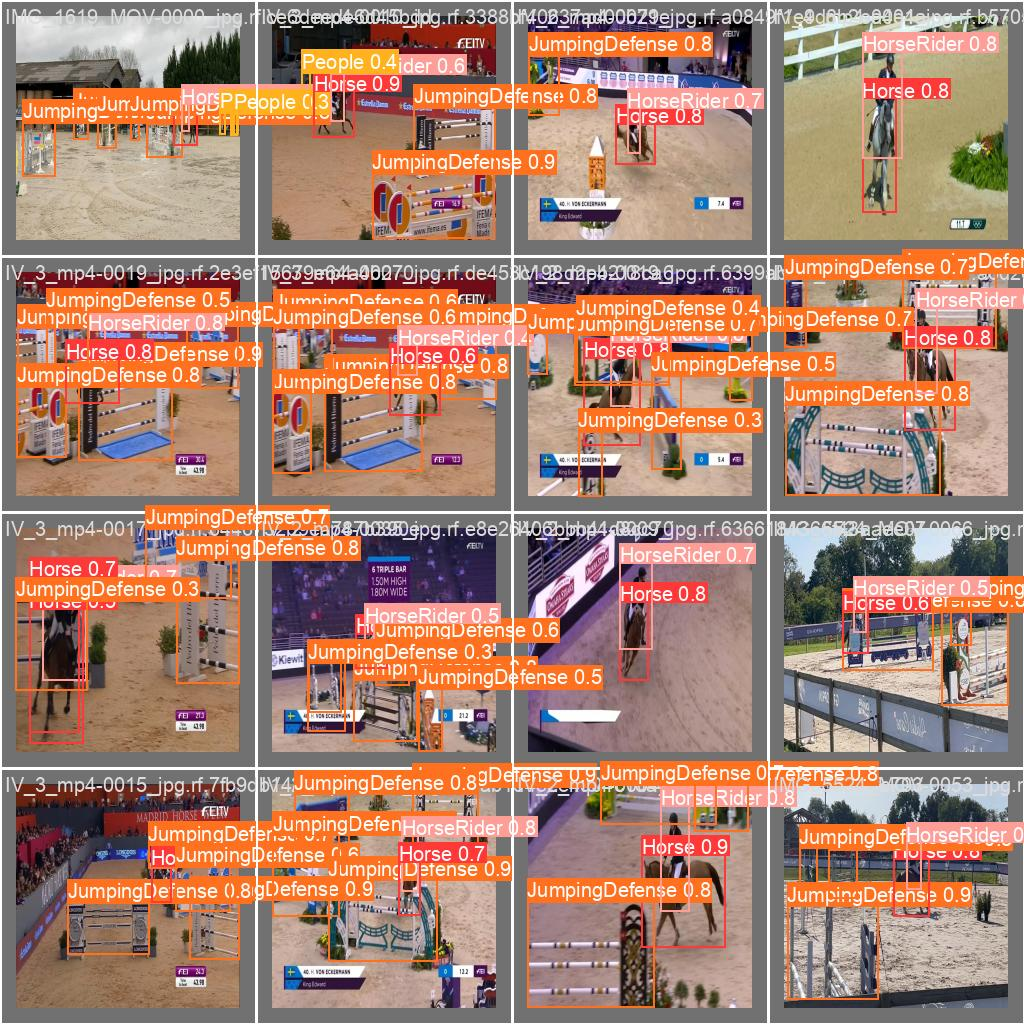

In [29]:
from IPython.display import Image

Image(filename=f"/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [32]:
%cd /home/student/demo/Equistrian/Yolo9/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data /home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml \
--weights /home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt

/home/student/demo/Equistrian/Yolo9/yolov9
val: data=/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml, weights=['/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.8.15 torch-2.2.2+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/valid/label
                 Class     Images  Instances          P          R      mAP50   
                   all        112        855      0.683      0.688      0.706      0.367
                 Horse        112        141      0.681    

## Inference with Custom Model

In [ ]:
%cd {HOME}/yolov9

In [33]:
%ls

Horse_seg-7/   data/       models/           segment/         val.py
README.md      detect.py   panoptic/         train.py         val_dual.py
__pycache__/   export.py   requirements.txt  train_dual.py    val_triple.py
benchmarks.py  figure/     runs/             train_triple.py  {HOME}/
classify/      hubconf.py  scripts/          utils/


In [44]:
!python detect.py --weights /home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt --conf 0.4 --source '/home/student/demo/Equistrian/Yolo9/Output_frames/frame_2.png' --save-txt --save-conf

detect: weights=['/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt'], source=/home/student/demo/Equistrian/Yolo9/Output_frames/frame_2.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.8.15 torch-2.2.2+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
image 1/1 /home/student/demo/Equistrian/Yolo9/Output_frames/frame_2.png: 384x640 1 Horse, 1 HorseRider, 1 JumpingDefense, 167.7ms
Speed: 0.4ms pre-process, 167.7ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp7
1 l

In [35]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 27.1 MB/s eta 0:00:00


In [36]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-t7rulu1o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-t7rulu1o
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=5273cd3919c731ac45a8fb25613fbe47531f7cd26f1fd0c3eaddc4bcc2ff420c
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1byn7qb/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything
--2024-04-22 14:10:04--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.33, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227

In [ ]:
import cv2
import numpy as np
import subprocess
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Set paths for the video and model
video_path = '/content/chk03.mp4'
output_path = '/content/output_video.mp4'
weights_path = '/content/yolov9/runs/train/exp15/weights/best.pt'
sam_checkpoint = '/content/yolov9/sam_vit_h_4b8939.pth'

# Run YOLOv9 detection on the video
subprocess.run([
    'python', '/content/yolov9/detect.py',
    '--weights', weights_path,
    '--conf', '0.4',
    '--source', video_path,
    '--save-txt', '--save-conf'
])

# Initialize SAM model
model_type = 'vit_h'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Process detections and apply segmentation
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (1920, 1080))

frame_idx = 1
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for SAM model compatibility
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Set the current frame in the predictor
    predictor.set_image(frame_rgb)

    # Read detection results
    detection_file = f'/content/yolov9/runs/detect/exp9/labels/chk03_{frame_idx}.txt'
    print(detection_file)
    with open(detection_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 6:
                class_id, x, y, w, h, conf = map(float, parts)
                # Calculate bbox coordinates
                bbox = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]
                # Segment with SAM
                masks, _, _ = predictor.predict(box=np.array(bbox).reshape(1, 4), multimask_output=False)
                # Apply mask to frame
                mask = masks[0] > 0.5
                for c in range(3):
                    frame[..., c] = np.where(mask, frame[..., c] * 0.5 + 128, frame[..., c])
            else:
                print("Unexpected format:", parts)

    # Convert frame back to BGR for video writing
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)
    frame_idx += 1

cap.release()
out.release()
# cv2.destroyAllWindows()

/content/yolov9/runs/detect/exp9/labels/chk03_1.txt
/content/yolov9/runs/detect/exp9/labels/chk03_2.txt
/content/yolov9/runs/detect/exp9/labels/chk03_3.txt
/content/yolov9/runs/detect/exp9/labels/chk03_4.txt


error: OpenCV(4.8.0) /io/opencv/modules/highgui/src/window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [5]:
import cv2
import numpy as np
import subprocess
from segment_anything import sam_model_registry, SamPredictor

# Set paths for the video and models
video_path = '/home/student/demo/Equistrian/Yolo9/test01.mp4'
output_path = '/home/student/demo/Equistrian/Yolo9/test01_out.avi'  # Changed to .avi
weights_path = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt'
sam_checkpoint = '/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth'

# Run YOLOv9 detection on the video
subprocess.run([
    'python', '/home/student/demo/Equistrian/Yolo9/yolov9/detect.py',
    '--weights', weights_path,
    '--conf', '0.4',
    '--source', video_path,
    '--save-txt', '--save-conf'
])

# Initialize SAM model
model_type = 'vit_h'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Process detections and apply segmentation
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Changed to XVID
out = cv2.VideoWriter(output_path, fourcc, 20.0, (1920, 1080))

frame_idx = 1
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for SAM model compatibility
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    predictor.set_image(frame_rgb)

    # Read detection results
    detection_file = f'/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_{frame_idx}.txt'
    print(detection_file)
    # if frame_idx >= 4:
    #   break
    with open(detection_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 6:
                class_id, x, y, w, h, conf = map(float, parts)
                bbox = [x - w / 2, y - h / 2, x + w / 2, y + h / 2]
                masks, _, _ = predictor.predict(box=np.array(bbox).reshape(1, 4), multimask_output=False)
                mask = masks[0] > 0.5
                for c in range(3):
                    frame[..., c] = np.where(mask, frame[..., c] * 0.5 + 128, frame[..., c])

    # Convert frame back to BGR for video writing
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)
    frame_output_path = f'/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_{frame_idx}.png'
    cv2.imwrite(frame_output_path, frame_bgr)
    frame_idx += 1

cap.release()
out.release()


detect: weights=['/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt'], source=/home/student/demo/Equistrian/Yolo9/test01.mp4, data=yolov9/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov9/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.8.15 torch-2.2.2+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
video 1/1 (1/45) /home/student/demo/Equistrian/Yolo9/test01.mp4: 384x640 1 Horse, 1 HorseRider, 1 JumpingDefense, 148.0ms
video 1/1 (2/45) /home/student/demo/Equistrian/Yolo9/test01.mp4: 384x640 1 Horse, 1 HorseRider, 1 JumpingDefense, 20.9ms
video 1/1 (3/45)

/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_1.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_2.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_3.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_4.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_5.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_6.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_7.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_8.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_9.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_10.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_11.txt
/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_12.txt
/home/student/demo/Equist

In [5]:
import cv2
sam_checkpoint = '/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth'
# Specify the path to your image
image_path = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_1.png'

# Read the image to get its dimensions
image = cv2.imread(image_path)
image_height, image_width, _ = image.shape

detections_path = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/frame_1.txt'

bboxes = []
class_ids = []
conf_scores = []

with open(detections_path, 'r') as file:
    for line in file:
        components = line.split()
        class_id = int(components[0])
        confidence = float(components[5])
        cx, cy, w, h = [float(x) for x in components[1:5]]

        # Convert from normalized [0, 1] to image scale
        cx *= image_width
        cy *= image_height
        w *= image_width
        h *= image_height

        # Convert the center x, y, width, and height to xmin, ymin, xmax, ymax
        xmin = cx - w / 2
        ymin = cy - h / 2
        xmax = cx + w / 2
        ymax = cy + h / 2

        class_ids.append(class_id)
        bboxes.append((xmin, ymin, xmax, ymax))
        conf_scores.append(confidence)

# Display the results
for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
    print(f'Class ID: {class_id}, Confidence: {conf:.2f}, BBox coordinates: {bbox}')

Class ID: 2, Confidence: 0.63, BBox coordinates: (543.9999999999999, 223.0002, 1043.0003199999999, 593.00028)
Class ID: 0, Confidence: 0.66, BBox coordinates: (702.9996799999999, 132.99983999999998, 1055.99936, 497.99951999999996)
Class ID: 1, Confidence: 0.81, BBox coordinates: (775.0003200000001, 92.99987999999998, 924.0, 276.00012)


In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# sam_checkpoint = "/content/drive/MyDrive/Trimester02/YOLO/yolov9/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [8]:
import cv2
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

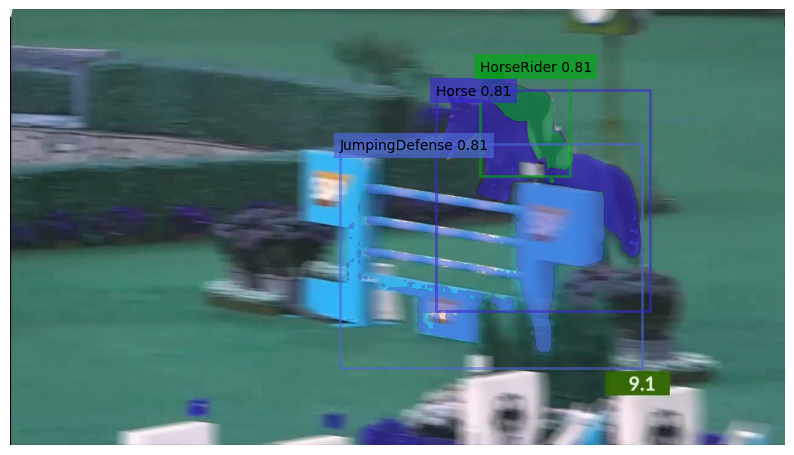

In [9]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import yaml

with open('/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml', 'r') as file:
    coco_data = yaml.safe_load(file)
    class_names = coco_data['names']

for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
    class_name = class_names[class_id]
    # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')

color_map = {}
for class_id in class_ids:
    color_map[class_id] = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)

def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, label, conf_score, color, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    rect = plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor='none', lw=2)
    ax.add_patch(rect)

    label_offset = 10

    # Construct the label with the class name and confidence score
    label_text = f'{label} {conf_score:.2f}'

    ax.text(x0, y0 - label_offset, label_text, color='black', fontsize=10, va='top', ha='left',
            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='square,pad=0.4'))

plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(image)

# Display and process each bounding box with the corresponding mask
for class_id, bbox in zip(class_ids, bboxes):
    class_name = class_names[class_id]
    # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')

    color = color_map[class_id]
    input_box = np.array(bbox)

    # Generate the mask for the current bounding box
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box,
        multimask_output=False,
    )

    show_mask(masks[0], ax, color=color)
    show_box(bbox, class_name, conf, color, ax)

# Show the final plot
plt.axis('off')
plt.show()

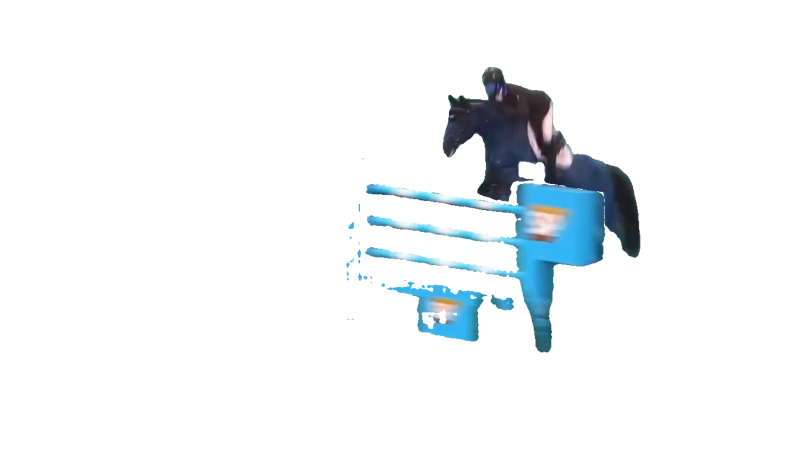

In [10]:
aggregate_mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Generate and accumulate masks for all bounding boxes
for bbox in bboxes:
    input_box = np.array(bbox).reshape(1, 4)
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box,
        multimask_output=False,
    )
    aggregate_mask = np.where(masks[0] > 0.5, 1, aggregate_mask)

# Convert the aggregate segmentation mask to a binary mask
binary_mask = np.where(aggregate_mask == 1, 1, 0)

# Create a white background with the same size as the image
white_background = np.ones_like(image) * 255

# Apply the binary mask to the original image
# Where the binary mask is 0 (background), use white_background; otherwise, use the original image
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]



# Display the new image with the detections and white background
plt.figure(figsize=(10, 10))
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [16]:
import cv2
sam_checkpoint = '/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth'
# Specify the path to your image
fi=3
for fi in range(1, 46):
    image_path = f'/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_{fi}.png'
    
    # Read the image to get its dimensions
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    
    detections_path = f'/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/frame_{fi}.txt'
    
    bboxes = []
    class_ids = []
    conf_scores = []
    
    with open(detections_path, 'r') as file:
        for line in file:
            components = line.split()
            class_id = int(components[0])
            confidence = float(components[5])
            cx, cy, w, h = [float(x) for x in components[1:5]]
    
            # Convert from normalized [0, 1] to image scale
            cx *= image_width
            cy *= image_height
            w *= image_width
            h *= image_height
    
            # Convert the center x, y, width, and height to xmin, ymin, xmax, ymax
            xmin = cx - w / 2
            ymin = cy - h / 2
            xmax = cx + w / 2
            ymax = cy + h / 2
    
            class_ids.append(class_id)
            bboxes.append((xmin, ymin, xmax, ymax))
            conf_scores.append(confidence)
    
    # Display the results
    for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
        print(f'Class ID: {class_id}, Confidence: {conf:.2f}, BBox coordinates: {bbox}')
    
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
    # sam_checkpoint = "/content/drive/MyDrive/Trimester02/YOLO/yolov9/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    predictor = SamPredictor(sam)
    
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    import matplotlib.patches as patches
    from matplotlib import pyplot as plt
    import numpy as np
    import yaml
    
    with open('/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml', 'r') as file:
        coco_data = yaml.safe_load(file)
        class_names = coco_data['names']
    
    for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
        class_name = class_names[class_id]
        # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')
    
    color_map = {}
    for class_id in class_ids:
        color_map[class_id] = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    
    def show_mask(mask, ax, color):
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
        ax.imshow(mask_image)
    
    def show_box(box, label, conf_score, color, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        rect = plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor='none', lw=2)
        ax.add_patch(rect)
    
        label_offset = 10
    
        # Construct the label with the class name and confidence score
        label_text = f'{label} {conf_score:.2f}'
    
        ax.text(x0, y0 - label_offset, label_text, color='black', fontsize=10, va='top', ha='left',
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='square,pad=0.4'))
    
    # plt.figure(figsize=(10, 10))
    # ax = plt.gca()
    # plt.imshow(image)
    # plt.figure()
    
    # Display and process each bounding box with the corresponding mask
    for class_id, bbox in zip(class_ids, bboxes):
        class_name = class_names[class_id]
        # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')
    
        color = color_map[class_id]
        input_box = np.array(bbox)
    
        # Generate the mask for the current bounding box
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )
    
        show_mask(masks[0], ax, color=color)
        show_box(bbox, class_name, conf, color, ax)
    aggregate_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # Generate and accumulate masks for all bounding boxes
    for bbox in bboxes:
        input_box = np.array(bbox).reshape(1, 4)
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )
        aggregate_mask = np.where(masks[0] > 0.5, 1, aggregate_mask)
    
    # Convert the aggregate segmentation mask to a binary mask
    binary_mask = np.where(aggregate_mask == 1, 1, 0)
    
    # Create a white background with the same size as the image
    white_background = np.ones_like(image) * 255
    
    # Apply the binary mask to the original image
    # Where the binary mask is 0 (background), use white_background; otherwise, use the original image
    new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]
    
    save_path = f'/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_mask/frame_{fi}.png'

    # Save the new image to the specified path
    cv2.imwrite(save_path, new_image)
    print(f'File frame_{fi} is saved')
print('Finish!') 
    # Display the new image with the detections and white background
    # plt.figure(figsize=(10, 10))
    # plt.imshow(new_image.astype(np.uint8))
    # plt.axis('off')
    # plt.show()

Class ID: 2, Confidence: 0.75, BBox coordinates: (297.99936, 266.00004, 673.99936, 582.00012)
Class ID: 1, Confidence: 0.79, BBox coordinates: (822.99936, 183.9996, 908.99936, 430.99992)
Class ID: 0, Confidence: 0.87, BBox coordinates: (751.99936, 250.99991999999995, 1046.99968, 545.9997599999999)
File frame_1 is saved
Class ID: 2, Confidence: 0.75, BBox coordinates: (318.0, 262.00044, 702.99968, 583.0002000000001)
Class ID: 1, Confidence: 0.82, BBox coordinates: (809.0006400000001, 165.00023999999996, 907.0006400000001, 421.99992)
Class ID: 0, Confidence: 0.86, BBox coordinates: (750.0, 235.99980000000002, 1037.0003199999999, 540.99972)
File frame_2 is saved
Class ID: 2, Confidence: 0.76, BBox coordinates: (355.00031999999993, 263.99988, 718.00064, 582.0001199999999)
Class ID: 1, Confidence: 0.83, BBox coordinates: (808.0006400000001, 160.99991999999997, 908.0006400000001, 406.00008)
Class ID: 0, Confidence: 0.83, BBox coordinates: (752.99968, 213.99984, 1026.9990400000002, 497.00016)

In [24]:
input_folder = "/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_seg"
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')]
ii= sorted(image_files)
print(ii)

['frame_01.png', 'frame_02.png', 'frame_03.png', 'frame_04.png', 'frame_05.png', 'frame_06.png', 'frame_07.png', 'frame_08.png', 'frame_10.png', 'frame_11.png', 'frame_12.png', 'frame_13.png', 'frame_14.png', 'frame_15.png', 'frame_16.png', 'frame_17.png', 'frame_18.png', 'frame_19.png', 'frame_20.png', 'frame_21.png', 'frame_22.png', 'frame_23.png', 'frame_24.png', 'frame_25.png', 'frame_26.png', 'frame_27.png', 'frame_28.png', 'frame_29.png', 'frame_30.png', 'frame_31.png', 'frame_32.png', 'frame_33.png', 'frame_34.png', 'frame_35.png', 'frame_36.png', 'frame_37.png', 'frame_38.png', 'frame_39.png', 'frame_40.png', 'frame_41.png', 'frame_42.png', 'frame_43.png', 'frame_44.png', 'frame_45.png', 'frame_9.png']


In [26]:
import cv2
import os

def create_video_from_frames(input_folder, output_video_path, fps):
    # Get the list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')]

    # Sort the image files based on their names
    image_files.sort()

    # Get the dimensions of the first image
    img = cv2.imread(os.path.join(input_folder, image_files[0]))
    height, width, _ = img.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if needed
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each frame to the video
    for image_file in image_files:
        img = cv2.imread(os.path.join(input_folder, image_file))
        video_writer.write(img)

    # Release video writer
    video_writer.release()

    print("Video created successfully!")

# Example usage
input_folder = "/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_mask"
output_video_path = "/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_mask/output_video_mask.mp4"
fps = 30  # Frames per second
create_video_from_frames(input_folder, output_video_path, fps)


Video created successfully!


In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml
from segment_anything import sam_model_registry, SamPredictor

def segment_images(image_paths, detections_paths, sam_checkpoint, save_path):
    for image_path, detections_path in zip(image_paths, detections_paths):
        # Read the image to get its dimensions
        image = cv2.imread(image_path)
        image_height, image_width, _ = image.shape

        bboxes = []
        class_ids = []
        conf_scores = []

        with open(detections_path, 'r') as file:
            for line in file:
                components = line.split()
                class_id = int(components[0])
                confidence = float(components[5])
                cx, cy, w, h = [float(x) for x in components[1:5]]

                # Convert from normalized [0, 1] to image scale
                cx *= image_width
                cy *= image_height
                w *= image_width
                h *= image_height

                # Convert the center x, y, width, and height to xmin, ymin, xmax, ymax
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                class_ids.append(class_id)
                bboxes.append((xmin, ymin, xmax, ymax))
                conf_scores.append(confidence)

        model_type = "vit_h"
        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        predictor = SamPredictor(sam)

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

        with open('/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml', 'r') as file:
            coco_data = yaml.safe_load(file)
            class_names = coco_data['names']

        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        plt.imshow(image)

        color_map = {}
        for class_id in class_ids:
            color_map[class_id] = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)

        def show_mask(mask, ax, color):
            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
            ax.imshow(mask_image)

        def show_box(box, label, conf_score, color, ax):
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor='none', lw=2)
            ax.add_patch(rect)

            label_offset = 10

            # Construct the label with the class name and confidence score
            label_text = f'{label} {conf_score:.2f}'

            ax.text(x0, y0 - label_offset, label_text, color='black', fontsize=10, va='top', ha='left',
                    bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='square,pad=0.4'))

        # Display and process each bounding box with the corresponding mask
        for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
            class_name = class_names[class_id]
            color = color_map[class_id]
            input_box = np.array(bbox)

            # Generate the mask for the current bounding box
            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box,
                multimask_output=False,
            )

            show_mask(masks[0], ax, color=color)
            show_box(bbox, class_name, conf, color, ax)

        # Save the segmented image
        save_file = f"{save_path}/{image_path.split('/')[-1]}"
        plt.axis('off')
        plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
        plt.close()

# Example usage
image_paths = ['/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_1.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_2.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_3.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_4.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_5.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_6.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_7.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_8.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_9.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_10.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_11.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_12.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_13.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_14.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_15.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_16.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_17.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_18.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_19.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_20.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_21.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_22.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_23.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_24.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_25.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_26.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_27.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_28.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_29.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_30.png',
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_31.png',               
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_32.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_33.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_34.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_35.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_36.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_37.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_38.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_39.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_40.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_41.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_42.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_43.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_44.png',              
            '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_45.png'            
              ]
detections_paths = ['/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_1.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_2.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_3.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_4.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_5.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_6.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_7.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_8.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_9.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_10.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_11.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_12.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_13.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_14.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_15.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_16.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_17.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_18.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_19.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_20.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_21.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_22.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_23.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_24.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_25.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_26.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_27.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_28.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_29.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_30.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_31.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_32.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_33.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_34.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_35.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_36.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_37.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_38.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_39.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_40.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_41.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_42.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_43.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_44.txt',
                   '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/test01_45.txt'

                   ]
sam_checkpoint = "/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth"
save_path = "/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_seg"

segment_images(image_paths, detections_paths, sam_checkpoint, save_path)


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
from segment_anything import sam_model_registry, SamPredictor

# Path to the directory containing the images
images_dir = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/'

# Path to the directory containing the detection labels
detections_dir = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp12/labels/'

# Path to the directory to save the processed images
output_dir = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames_mask'

# Load SAM model
sam_checkpoint = "/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Load class names
with open('/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml', 'r') as file:
    coco_data = yaml.safe_load(file)
    class_names = coco_data['names']

# Function to show mask
def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

# Function to show bounding box
def show_box(box, label, conf_score, color, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    rect = plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor='none', lw=2)
    ax.add_patch(rect)

    label_offset = 10
    label_text = f'{label} {conf_score:.2f}'
    ax.text(x0, y0 - label_offset, label_text, color='black', fontsize=10, va='top', ha='left',
            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='square,pad=0.4'))

# Process each image
for filename in os.listdir(images_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(images_dir, filename)
        detections_path = os.path.join(detections_dir, f'{os.path.splitext(filename)[0]}.txt')

        # Read the image to get its dimensions
        image = cv2.imread(image_path)
        image_height, image_width, _ = image.shape

        bboxes = []
        class_ids = []
        conf_scores = []

        # Read detection labels
        with open(detections_path, 'r') as file:
            for line in file:
                components = line.split()
                class_id = int(components[0])
                confidence = float(components[5])
                cx, cy, w, h = [float(x) for x in components[1:5]]

                cx *= image_width
                cy *= image_height
                w *= image_width
                h *= image_height

                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                class_ids.append(class_id)
                bboxes.append((xmin, ymin, xmax, ymax))
                conf_scores.append(confidence)

        # Convert image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image_rgb)

        # Create figure
        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        plt.imshow(image_rgb)

        # Display bounding boxes and masks
        for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
            class_name = class_names[class_id]
            color = np.random.rand(3)
            show_box(bbox, class_name, conf, color, ax)

            input_box = np.array(bbox).reshape(1, 4)
            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box,
                multimask_output=False,
            )
            show_mask(masks[0], ax, color=color)

        # Save processed image
        plt.axis('off')
        output_path = os.path.join(output_dir, filename)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

print("Processing complete.")


In [20]:
image = cv2.cvtColor(cv2.imread('/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/output_frames/frame_1.png'), cv2.COLOR_BGR2RGB)

In [61]:
import cv2
import numpy as np
import yaml
from segment_anything import sam_model_registry, SamPredictor

def read_detections(detection_path, image_shape):
    bboxes = []
    class_ids = []
    conf_scores = []
    image_height, image_width = image_shape[:2]

    with open(detection_path, 'r') as file:
        for line in file:
            components = line.split()
            class_id = int(components[0])
            confidence = float(components[5])
            cx, cy, w, h = [float(x) for x in components[1:5]]
            cx *= image_width
            cy *= image_height
            w *= image_width
            h *= image_height
            xmin = cx - w / 2
            ymin = cy - h / 2
            xmax = cx + w / 2
            ymax = cy + h / 2
            bboxes.append((xmin, ymin, xmax, ymax))
            class_ids.append(class_id)
            conf_scores.append(confidence)
    return bboxes, class_ids, conf_scores

def process_frame(frame, predictor, bboxes, class_ids, coco_data):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    predictor.set_image(frame_rgb)
    color_map = {cid: np.random.rand(3,) for cid in class_ids}
    
    for bbox, class_id in zip(bboxes, class_ids):
        masks, _, _ = predictor.predict(
            box=np.array(bbox).reshape(1, 4), 
            multimask_output=False
        )
        mask = masks[0] > 0.5
        class_name = coco_data['names'][class_id]
        for c in range(3):
            frame[..., c] = np.where(mask, frame[..., c] * 0.5 + 128, frame[..., c])

        # Draw bounding box (optional)
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color_map[class_id], 2)

    return frame

def main(video_path, output_path, weights_path, sam_checkpoint, detections_folder, coco_file):
    # Load models
    model_type = 'vit_h'
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    predictor = SamPredictor(sam)

    # Load class names
    with open(coco_file, 'r') as file:
        coco_data = yaml.safe_load(file)

    cap = cv2.VideoCapture(video_path)
    frame_idx = 1
    
    ret1, frame1 = cap.read()
    height, width = frame1[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # You can change 'MP4V' to 'XVID' if you prefer
    out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx < 6:
            break
        detection_file = f'{detections_folder}/test01_{frame_idx}.txt'
        print(detection_file)
        bboxes, class_ids, conf_scores = read_detections(detection_file, frame.shape)
        frame = process_frame(frame, predictor, bboxes, class_ids, coco_data)
        
        out.write(frame)
        
        cv2.imwrite(f'{output_path}/frame_{frame_idx}.png', frame)
        frame_idx += 1

    cap.release()
    out.release()




video_path = '/home/student/demo/Equistrian/Yolo9/test01.mp4'
output_path = '/home/student/demo/Equistrian/Yolo9/Output_frames'
weights_path = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/train/exp3/weights/best.pt'
sam_checkpoint = '/home/student/demo/Equistrian/Yolo9/yolov9/sam_vit_h_4b8939.pth'
detections_folder = '/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp6/labels'
coco_file = '/home/student/demo/Equistrian/Yolo9/yolov9/Horse_seg-7/data.yaml'

main(video_path, output_path, weights_path, sam_checkpoint, detections_folder, coco_file)

[ERROR:0@8777.863] global cap.cpp:643 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /home/student/demo/Equistrian/Yolo9/Output_frames in function 'icvExtractPattern'




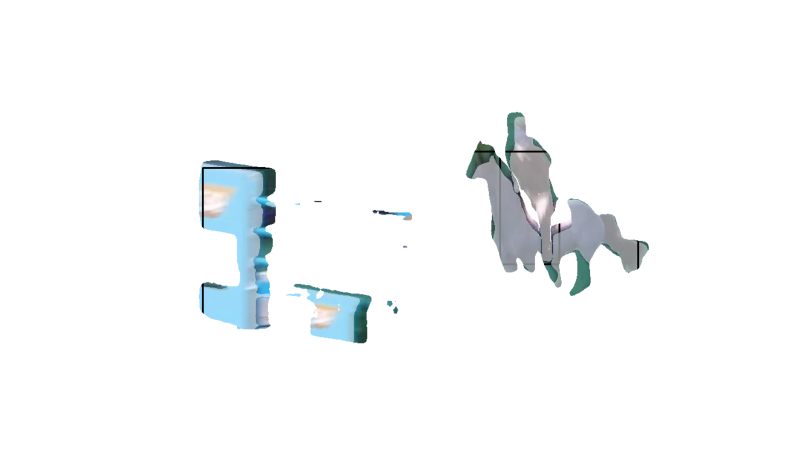

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor

def apply_segmentation_masks(image, bboxes, predictor):
    """
    Apply segmentation masks to the given image based on bounding boxes.

    Args:
    image (numpy.ndarray): The image on which masks will be applied.
    bboxes (list of tuples): Bounding boxes where each box is a tuple (xmin, ymin, xmax, ymax).
    predictor (SamPredictor): The segmentation model predictor.

    Returns:
    numpy.ndarray: The image with segmentation masks applied.
    """
    aggregate_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Generate and accumulate masks for each bounding box
    for bbox in bboxes:
        input_box = np.array(bbox).reshape(1, 4)
        masks, _, _ = predictor.predict(box=input_box, multimask_output=False)
        aggregate_mask = np.where(masks[0] > 0.5, 1, aggregate_mask)

    # Convert the aggregate mask to a binary mask
    binary_mask = np.where(aggregate_mask == 1, 1, 0)

    # Create a white background
    white_background = np.ones_like(image) * 255

    # Apply the binary mask to the original image
    new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

    return new_image

# Example of using the function (assuming 'image', 'bboxes', and 'predictor' are already defined)


path = '/home/student/demo/Equistrian/Yolo9/Output_frames/frame_2.png'
image = cv2.imread(path)
bboxes, class_ids, conf_scores = read_detections('/home/student/demo/Equistrian/Yolo9/yolov9/runs/detect/exp6/labels/test01_2.txt', image.shape)
frame = process_frame(frame, predictor, bboxes, class_ids, coco_data)

segmented_image = apply_segmentation_masks(image, bboxes, predictor)

# Display the new image with the detections and white background
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [ ]:
import cv2

def bbox_generator(image_path, detections_path):

  # image_path = '/content/yolov9/runs/detect/exp5/2.png'

  # Read the image to get its dimensions
  # image = cv2.imread(image_path)
  image_height, image_width, _ = image_path.shape

  # detections_path = '/content/yolov9/runs/detect/exp5/labels/2.txt'

  bboxes = []
  class_ids = []
  conf_scores = []

  with open(detections_path, 'r') as file:
      for line in file:
          components = line.split()
          class_id = int(components[0])
          confidence = float(components[5])
          cx, cy, w, h = [float(x) for x in components[1:5]]

          # Convert from normalized [0, 1] to image scale
          cx *= image_width
          cy *= image_height
          w *= image_width
          h *= image_height

          # Convert the center x, y, width, and height to xmin, ymin, xmax, ymax
          xmin = cx - w / 2
          ymin = cy - h / 2
          xmax = cx + w / 2
          ymax = cy + h / 2

          class_ids.append(class_id)
          bboxes.append((xmin, ymin, xmax, ymax))
          conf_scores.append(confidence)

  # Display the results
  for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
      print(f'Class ID: {class_id}, Confidence: {conf:.2f}, BBox coordinates: {bbox}')
  return bboxes, class_ids, conf_scores


In [ ]:
import cv2
import os
import json

def process_video_frames(video_path, detections_base_path, save_path):
    cap = cv2.VideoCapture(video_path)
    frame_counter = 1

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detection_file_path = os.path.join(detections_base_path, f'chk07_{frame_counter}.txt')

        if os.path.exists(detection_file_path):
            bboxes, class_ids, conf_scores = bbox_generator(frame, detection_file_path)
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            predictor.set_image(image)

            # Assuming get_state() retrieves the necessary state of the predictor
            # Replace this with the actual method to get your predictor's state or output
            predictor_state = predictor.

            # Save the frame's data
            frame_data = {
                'frame_number': frame_counter,
                'bboxes': bboxes,
                'class_ids': class_ids,
                'conf_scores': conf_scores,
                'predictor_state': predictor_state,
            }

            with open(os.path.join(save_path, f'frame_{frame_counter}.json'), 'w') as f:
                json.dump(frame_data, f)

        frame_counter += 1

    cap.release()

# Example usage
video_path = '/content/drive/MyDrive/Trimester02/YOLO/yolov9/runs/detect/exp8/chk07.mp4'
detections_base_path = '/content/drive/MyDrive/Trimester02/YOLO/yolov9/runs/detect/exp8/labels'
save_path = '/content/drive/MyDrive/Trimester02/YOLO/yolov9/frames_data/'
process_video_frames(video_path, detections_base_path, save_path)


In [ ]:
import cv2
image = cv2.cvtColor(cv2.imread('/content/yolov9/runs/detect/exp5/2.png'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [ ]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import yaml

with open('/content/drive/MyDrive/Trimester02/YOLO/yolov9/Horse_seg-3/data.yaml', 'r') as file:
    coco_data = yaml.safe_load(file)
    class_names = coco_data['names']

for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
    class_name = class_names[class_id]
    # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')

color_map = {}
for class_id in class_ids:
    color_map[class_id] = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)

def show_mask(mask, ax, color):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, label, conf_score, color, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    rect = plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor='none', lw=2)
    ax.add_patch(rect)

    label_offset = 10

    # Construct the label with the class name and confidence score
    label_text = f'{label} {conf_score:.2f}'

    ax.text(x0, y0 - label_offset, label_text, color='black', fontsize=10, va='top', ha='left',
            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', boxstyle='square,pad=0.4'))

plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(image)

# Display and process each bounding box with the corresponding mask
for class_id, bbox in zip(class_ids, bboxes):
    class_name = class_names[class_id]
    # print(f'Class ID: {class_id}, Class Name: {class_name}, BBox coordinates: {bbox}')

    color = color_map[class_id]
    input_box = np.array(bbox)

    # Generate the mask for the current bounding box
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box,
        multimask_output=False,
    )

    show_mask(masks[0], ax, color=color)
    show_box(bbox, class_name, conf, color, ax)

# Show the final plot
plt.axis('off')
plt.show()

In [ ]:
aggregate_mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Generate and accumulate masks for all bounding boxes
for bbox in bboxes:
    input_box = np.array(bbox).reshape(1, 4)
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box,
        multimask_output=False,
    )
    aggregate_mask = np.where(masks[0] > 0.5, 1, aggregate_mask)

# Convert the aggregate segmentation mask to a binary mask
binary_mask = np.where(aggregate_mask == 1, 1, 0)

# Create a white background with the same size as the image
white_background = np.ones_like(image) * 255

# Apply the binary mask to the original image
# Where the binary mask is 0 (background), use white_background; otherwise, use the original image
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

# Display the new image with the detections and white background
plt.figure(figsize=(10, 10))
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

In [ ]:
import cv2
import os

video_path = '/content/data/chk02.mp4'
detections_base_path = '/content/yolov9/runs/detect/exp6/labels/'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Codec used to encode the video
output_video_path = '/content/data/output1.mp4'  # Path to save the output video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))

# Initialize a frame counter
frame_counter = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop if no frames are read

    # Construct the path to the detection file for the current frame
    detection_file_path = os.path.join(detections_base_path, f'{frame_counter}.txt')

    # Check if the detection file exists for the current frame
    if os.path.exists(detection_file_path):
        bboxes = []
        class_ids = []
        conf_scores = []

        with open(detection_file_path, 'r') as file:
            for line in file:
                components = line.split()
                class_id = int(components[0])
                confidence = float(components[5])
                cx, cy, w, h = [float(x) for x in components[1:5]]

                # Convert from normalized [0, 1] to frame scale
                cx *= frame_width
                cy *= frame_height
                w *= frame_width
                h *= frame_height

                # Convert the center x, y, width, and height to xmin, ymin, xmax, ymax
                xmin = int(cx - w / 2)
                ymin = int(cy - h / 2)
                xmax = int(cx + w / 2)
                ymax = int(cy + h / 2)

                class_ids.append(class_id)
                bboxes.append((xmin, ymin, xmax, ymax))
                conf_scores.append(confidence)

        # Draw bounding boxes and class information on the frame
        for class_id, bbox, conf in zip(class_ids, bboxes, conf_scores):
            xmin, ymin, xmax, ymax = bbox
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(frame, f'Class: {class_id}, Conf: {conf:.2f}', (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the frame into the file 'output.mp4'
    out.write(frame)

    # Increment the frame counter
    frame_counter += 1

# Release everything when job is finished
cap.release()
out.release()



In [ ]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv9 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [ ]:
!pip install -q inference supervision

In [ ]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

**NOTE:** Before using your model in Inference, you first need to upload your weights to Roboflow Universe. Ensure to specify the correct `model_type` - `yolov9`, and that the project version matches the version of the dataset you used for training, denoted by `[1]`. In my case, it's `6`.

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/upload-roboflow-model.png)



In [ ]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp")

**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="football-players-detection-3zvbc/8", api_key=ROBOFLOW_API_KEY)

**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
import os
import zipfile

def zip_folder(folder_path, output_zip_path):
    """
    Compresses a folder into a ZIP file.

    Parameters:
    - folder_path: The path to the folder you want to compress.
    - output_zip_path: The path where the output ZIP file should be saved.
    """
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create a relative path for files to keep the directory structure
                relative_path = os.path.relpath(os.path.join(root, file), os.path.join(folder_path, '..'))
                zipf.write(os.path.join(root, file), arcname=relative_path)
    print(f'Folder {folder_path} is zipped into {output_zip_path} successfully!')

# Example usage
folder_to_zip = '/content/yolov9'
output_zip_file = '/content/drive/MyDrive/Trimester02/YOLO/yolov9.zip'
zip_folder(folder_to_zip, output_zip_file)
